In [1]:
# implementation of probabilistic matrix factorisation
# very roughly based off neural net in https://towardsdatascience.com/collaborative-filtering-and-embeddings-part-2-919da17ecefb

%load_ext autoreload
%autoreload 2

from utils import *

import pickle
import random
import numpy as np
from scipy.sparse import csr_matrix, save_npz, load_npz
from tqdm.notebook import tqdm
from itertools import chain
from collections import Counter, defaultdict
from pathlib import Path
from sklearn import metrics
import csv
import datetime
import tensorflow as tf
import math
import matplotlib.pyplot as plt

In [2]:
movieid_mid_lookup = get_movieid_mid_lookup(recompute=False)

In [3]:
user_Xs, movie_Xs, ys = get_dataset(train_set, include_ys=True, recompute=False)
user_val_Xs, movie_val_Xs, val_ys = get_dataset(val_set, include_ys=True, recompute=False)
user_test_Xs, movie_test_Xs = get_dataset(test_set, include_ys=False, recompute=False)
movie_genres_one_hot = get_movie_genres_one_hot(recompute=False)

train_genres = get_dataset_genres(train_set, dataset_includes_ys=True, recompute=False)
val_genres = get_dataset_genres(val_set, dataset_includes_ys=True, recompute=False)
test_genres = get_dataset_genres(test_set, dataset_includes_ys=False, recompute=False)

retrieving dataset from dataset/train_ratings_binary.csv
retrieving dataset from dataset/val_ratings_binary.csv
retrieving dataset from dataset/test_ratings.csv


no_genre_count = 0
total = 0

with open(test_set, newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for rating in tqdm(reader):
        if movieid_mid_lookup[int(float(rating["movieId"]))] not in movie_genres_one_hot:
            no_genre_count += 1
        total += 1

print(f"{no_genre_count}/{total} entries in the test data doesn't have genre info ({no_genre_count/total}%)")
# all movies in test data accounted for in genre information dataset

In [4]:
# # no memory - implicitly calculating user movie matrix from now on

# movie_embeddings = tf.Variable(tf.random_normal([5, NUM_MOVIES], stddev=0.03, dtype=tf.float32))
# user_embeddings = tf.Variable(tf.random_normal([NUM_USERS, 5], stddev=0.03, dtype=tf.float32))
# movie_bias = tf.Variable(tf.random_normal([1, NUM_MOVIES], stddev=0.03, dtype=tf.float32))
# user_bias = tf.Variable(tf.random_normal([NUM_USERS, 1], stddev=0.03, dtype=tf.float32))

# user_movie_score = tf.tensordot(user_embeddings, movie_embeddings, axes = 1)+.14*tf.tile(movie_bias, [NUM_USERS, 1]) +.87*tf.tile(user_bias, [1, NUM_MOVIES])


In [5]:
# use pca to reduce dimensions with preserved_variance=0.96875 => dim=768 (reduction by 32%), val mse=0.031122472 on scaled data
preserved_variance = 1

train_tags = get_tags(movie_Xs, preserved_variance, recompute=False)
val_tags = get_tags(movie_val_Xs, preserved_variance, recompute=False)
test_tags = get_tags(movie_test_Xs, preserved_variance, recompute=False)

NUM_PROJ_TAGS = train_tags[0].shape[0]
print(f"projected down to {NUM_PROJ_TAGS} dims from {NUM_TAGS} dimensions (reduced by {1-NUM_PROJ_TAGS/NUM_TAGS})")

  2%|▏         | 243189/11946576 [00:00<00:04, 2431880.72it/s]

getting tags


  6%|▌         | 220036/3999236 [00:00<00:01, 2200346.36it/s]

getting tags


  5%|▌         | 207547/4054451 [00:00<00:01, 2075462.08it/s]

getting tags


100%|██████████| 4054451/4054451 [00:01<00:00, 2570193.82it/s]

projected down to 1128 dims from 1128 dimensions (reduced by 0.0)


In [6]:
# THE MODEL

embedding_dim = 40
tag_embedded_dim = 40

movie_genre_embeddings = tf.placeholder(dtype=tf.float32, shape=[None, 20], name="movie_genre_placeholder")
movie_embeddings = tf.Variable(tf.contrib.layers.xavier_initializer(dtype=tf.float32)([NUM_MOVIES, embedding_dim]))
user_embeddings = tf.Variable(tf.contrib.layers.xavier_initializer(dtype=tf.float32)([NUM_USERS, embedding_dim]))
# movie_bias = tf.Variable(tf.random_normal([NUM_MOVIES], stddev=0.03, dtype=tf.float32))
# user_bias = tf.Variable(tf.random_normal([NUM_USERS], stddev=0.03, dtype=tf.float32))

user_slice_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1], name="uids") # columns vectors to do tensor slicing
movie_slice_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1], name="mids") # columns vectors to do tensor slicing
# user_bias_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing
# movie_bias_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing

user_embedding_columns = tf.reshape(tf.gather_nd(user_embeddings, user_slice_idxs), [-1, embedding_dim])
movie_embedding_rows = tf.reshape(tf.gather_nd(movie_embeddings, movie_slice_idxs), [-1, embedding_dim])
print("movie_embedding_rows shape", movie_embedding_rows.shape)

# user_slice_bias = tf.reshape(tf.gather_nd(user_bias, user_slice_idxs), [-1, 1])
# movie_slice_bias = tf.reshape(tf.gather_nd(movie_bias, movie_slice_idxs), [-1, 1])

tags = tf.placeholder(dtype=tf.float32, shape=[None, NUM_PROJ_TAGS], name="tags_placeholder")
tag_W1 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[NUM_PROJ_TAGS, 150], dtype=tf.float32))
tag_b1 = tf.Variable(initial_value=np.zeros(shape=[150], dtype=np.float32))
tag_l1 = tf.nn.relu(tf.matmul(tags, tag_W1) + tag_b1)

tag_W2 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[150, 40], dtype=tf.float32))
tag_b2 = tf.Variable(initial_value=np.zeros(shape=[40], dtype=np.float32))
tag_embedding = tf.nn.relu(tf.matmul(tag_l1, tag_W2) + tag_b2)

mult_input = movie_embedding_rows * user_embedding_columns

input_layer = tf.concat((
    tag_embedding,
    mult_input,
    movie_embedding_rows,
    movie_genre_embeddings,
    user_embedding_columns,
#     user_slice_bias,
#     movie_slice_bias
), axis=1)
print(movie_embedding_rows.shape, user_embedding_columns.shape)
print("input layer shape", input_layer.shape)

W1 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[int(input_layer.shape[1]), 60], dtype=tf.float32))
b1 = tf.Variable(initial_value=np.zeros(shape=[60], dtype=np.float32))
l1 = tf.nn.relu(tf.matmul(input_layer, W1) + b1)

W2 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[60, 20], dtype=tf.float32))
b2 = tf.Variable(initial_value=np.zeros(shape=[20], dtype=np.float32))
l2 = tf.nn.relu(tf.matmul(l1, W2) + b2)

W3 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[int(l2.shape[1]), 2], dtype=tf.float32))
b3 = tf.Variable(initial_value=np.zeros(shape=[2], dtype=np.float32))
l3 = tf.matmul(l2, W3) + b3
pred_y =tf.nn.sigmoid(l3)

# embedding_pred_vectors = tf.reshape(tf.reduce_sum(user_embedding_columns * tf.concat((movie_embedding_rows, movie_genre_embeddings), axis=1), axis=1), (-1, 1))
# pred_y = embedding_pred_vectors + .14*movie_slice_bias + .87*user_slice_bias
# print(embedding_pred_vectors.shape)
# print(pred_y.shape)

y_true = tf.placeholder(dtype=tf.float32, shape=[None, 2])

all_weights = [W1, b1, W2, b2, W3, b3, tag_W1, tag_b1, tag_W2, tag_b2]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



movie_embedding_rows shape (?, 40)
(?, 40) (?, 40)
input layer shape (?, 180)


epoch 0
training
train loss 0.5623396 l2 0.45042273 mse 0.5623396
train loss 0.55918056 l2 0.45056435 mse 0.55918056
train loss 0.5551396 l2 0.45086938 mse 0.5551396
train loss 0.55225414 l2 0.45131284 mse 0.55225414
train loss 0.5492067 l2 0.45184255 mse 0.5492067
train loss 0.54588693 l2 0.45246333 mse 0.54588693
train loss 0.5452452 l2 0.45318082 mse 0.5452452
train loss 0.5432783 l2 0.45396572 mse 0.5432783
train loss 0.542286 l2 0.45477822 mse 0.542286
train loss 0.54119676 l2 0.45557952 mse 0.54119676
train loss 0.5411352 l2 0.4563547 mse 0.5411352
train loss 0.5405503 l2 0.45701513 mse 0.5405503
train loss 0.53978676 l2 0.45764554 mse 0.53978676
train loss 0.5388192 l2 0.45820636 mse 0.5388192
train loss 0.53827935 l2 0.45874462 mse 0.53827935
train loss 0.5392937 l2 0.45925188 mse 0.5392937
train loss 0.5386296 l2 0.45973924 mse 0.5386296
train loss 0.5372436 l2 0.46019217 mse 0.5372436
train loss 0.53798664 l2 0.4606358 mse 0.53798664
train loss 0.5387144 l2 0.46106833 mse 0.5

train loss 0.5157094 l2 0.51355904 mse 0.5157094
train loss 0.51134676 l2 0.5139164 mse 0.51134676
train loss 0.5116524 l2 0.51431006 mse 0.5116524
train loss 0.51046294 l2 0.5147366 mse 0.51046294
train loss 0.51063704 l2 0.5151802 mse 0.51063704
train loss 0.5106271 l2 0.5156251 mse 0.5106271
train loss 0.5117151 l2 0.5160632 mse 0.5117151
train loss 0.512954 l2 0.5164675 mse 0.512954
train loss 0.50840575 l2 0.5168601 mse 0.50840575
train loss 0.510288 l2 0.51726425 mse 0.510288
train loss 0.50925565 l2 0.5176789 mse 0.50925565
train loss 0.50859034 l2 0.5181118 mse 0.50859034
train loss 0.5089524 l2 0.5185467 mse 0.5089524
val loss 0.5188878
val acc 0.7113521182545867 val auc 0.7831767295446451
epoch 7
training
train loss 0.5079379 l2 0.5189711 mse 0.5079379
train loss 0.50921774 l2 0.51939154 mse 0.50921774
train loss 0.5090404 l2 0.51978505 mse 0.5090404
train loss 0.51015586 l2 0.5201728 mse 0.51015586
train loss 0.51002645 l2 0.5205523 mse 0.51002645
train loss 0.5088373 l2 0.5

val loss 0.5192636
val acc 0.7091589493593277 val auc 0.7820268137551745
epoch 13
training
train loss 0.50708234 l2 0.5784352 mse 0.50708234
train loss 0.507059 l2 0.5790835 mse 0.507059
train loss 0.50688756 l2 0.57977986 mse 0.50688756
train loss 0.50802356 l2 0.5805245 mse 0.50802356
train loss 0.50901467 l2 0.58129966 mse 0.50901467
train loss 0.50794554 l2 0.58209366 mse 0.50794554
train loss 0.5089561 l2 0.5829088 mse 0.5089561
train loss 0.50984 l2 0.5837207 mse 0.50984
train loss 0.5117142 l2 0.5845 mse 0.5117142
train loss 0.51347786 l2 0.5852254 mse 0.51347786
train loss 0.513156 l2 0.5859045 mse 0.513156
train loss 0.5126344 l2 0.58653176 mse 0.5126344
train loss 0.51234853 l2 0.58711225 mse 0.51234853
train loss 0.51179975 l2 0.58766663 mse 0.51179975
train loss 0.50880617 l2 0.58820313 mse 0.50880617
train loss 0.5091739 l2 0.58873904 mse 0.5091739
train loss 0.50703 l2 0.58928204 mse 0.50703
train loss 0.50530463 l2 0.5898525 mse 0.50530463
train loss 0.5106104 l2 0.59046

train loss 0.50529057 l2 0.6910818 mse 0.50529057
train loss 0.5057284 l2 0.69163775 mse 0.5057284
train loss 0.5061046 l2 0.6921987 mse 0.5061046
train loss 0.5046246 l2 0.6927652 mse 0.5046246
train loss 0.5061574 l2 0.69334245 mse 0.5061574
train loss 0.50486857 l2 0.69393075 mse 0.50486857
train loss 0.5031972 l2 0.6945371 mse 0.5031972
train loss 0.5074788 l2 0.69516706 mse 0.5074788
train loss 0.50414056 l2 0.69580674 mse 0.50414056
train loss 0.50560343 l2 0.69645613 mse 0.50560343
train loss 0.50447637 l2 0.6971188 mse 0.50447637
train loss 0.5045145 l2 0.6978111 mse 0.5045145
train loss 0.50476646 l2 0.69852066 mse 0.50476646
val loss 0.5172584
val acc 0.7142509219260879 val auc 0.7878779872903089
epoch 20
training
train loss 0.504323 l2 0.6992377 mse 0.504323
train loss 0.50465906 l2 0.6999722 mse 0.50465906
train loss 0.5046419 l2 0.7007166 mse 0.5046419
train loss 0.5055803 l2 0.7014678 mse 0.5055803
train loss 0.50617886 l2 0.7022168 mse 0.50617886
train loss 0.504595 l2 0

train loss 0.5003736 l2 0.8375483 mse 0.5003736
val loss 0.51672024
val acc 0.7149855622423883 val auc 0.7904634811625822
epoch 26
training
train loss 0.49983376 l2 0.8383572 mse 0.49983376
train loss 0.50013745 l2 0.83915126 mse 0.50013745
train loss 0.4999475 l2 0.83993673 mse 0.4999475
train loss 0.50065213 l2 0.8407097 mse 0.50065213
train loss 0.5015006 l2 0.84147006 mse 0.5015006
train loss 0.4998389 l2 0.842225 mse 0.4998389
train loss 0.4996598 l2 0.84298474 mse 0.4996598
train loss 0.49985403 l2 0.8437697 mse 0.49985403
train loss 0.50076556 l2 0.84458023 mse 0.50076556
train loss 0.50241166 l2 0.8454164 mse 0.50241166
train loss 0.5020741 l2 0.8462711 mse 0.5020741
train loss 0.5019526 l2 0.8471325 mse 0.5019526
train loss 0.5021396 l2 0.84799075 mse 0.5021396
train loss 0.5024315 l2 0.8488359 mse 0.5024315
train loss 0.50045997 l2 0.8496738 mse 0.50045997
train loss 0.5018102 l2 0.8505074 mse 0.5018102
train loss 0.5000426 l2 0.85134745 mse 0.5000426
train loss 0.49785095 l2

train loss 0.49904242 l2 0.9826904 mse 0.49904242
train loss 0.49822208 l2 0.9839156 mse 0.49822208
train loss 0.4979682 l2 0.98511755 mse 0.4979682
train loss 0.49794906 l2 0.9862934 mse 0.49794906
train loss 0.49838424 l2 0.98744726 mse 0.49838424
train loss 0.49698386 l2 0.9885974 mse 0.49698386
train loss 0.49864766 l2 0.98975295 mse 0.49864766
train loss 0.49734092 l2 0.99090916 mse 0.49734092
train loss 0.49544784 l2 0.9920624 mse 0.49544784
train loss 0.4994783 l2 0.9932143 mse 0.4994783
train loss 0.49629548 l2 0.9943601 mse 0.49629548
train loss 0.49745074 l2 0.9954935 mse 0.49745074
train loss 0.49611712 l2 0.99661845 mse 0.49611712
train loss 0.49632102 l2 0.99774027 mse 0.49632102
train loss 0.49681196 l2 0.99884415 mse 0.49681196
val loss 0.51724714
val acc 0.7195039252497227 val auc 0.7960810806809299
epoch 33
training
train loss 0.49655315 l2 0.9999163 mse 0.49655315
train loss 0.49706438 l2 1.0009642 mse 0.49706438
train loss 0.49699312 l2 1.0019991 mse 0.49699312
train

train loss 0.50134057 l2 1.2056231 mse 0.50134057
train loss 0.50160766 l2 1.2075328 mse 0.50160766
train loss 0.5018636 l2 1.2093475 mse 0.5018636
val loss 0.5191864
val acc 0.7137743308972013 val auc 0.7930340641263649
epoch 39
training
train loss 0.50106895 l2 1.2110485 mse 0.50106895
train loss 0.50098604 l2 1.2126446 mse 0.50098604
train loss 0.49968433 l2 1.2141598 mse 0.49968433
train loss 0.4994394 l2 1.2156096 mse 0.4994394
train loss 0.4990668 l2 1.2170265 mse 0.4990668
train loss 0.49627537 l2 1.2184626 mse 0.49627537
train loss 0.4953587 l2 1.2199626 mse 0.4953587
train loss 0.49567342 l2 1.2215729 mse 0.49567342
train loss 0.49727985 l2 1.2233186 mse 0.49727985
train loss 0.50017345 l2 1.2252061 mse 0.50017345
train loss 0.5007788 l2 1.2272319 mse 0.5007788
train loss 0.50147325 l2 1.2293831 mse 0.50147325
train loss 0.50174266 l2 1.2316308 mse 0.50174266
train loss 0.5012591 l2 1.2339585 mse 0.5012591
train loss 0.49959433 l2 1.2363625 mse 0.49959433
train loss 0.5005965 

train loss 0.4894384 l2 1.4724712 mse 0.4894384
train loss 0.48979968 l2 1.4743043 mse 0.48979968
train loss 0.4911157 l2 1.4761215 mse 0.4911157
train loss 0.49022958 l2 1.4779168 mse 0.49022958
train loss 0.49013633 l2 1.4796886 mse 0.49013633
train loss 0.4901804 l2 1.4814401 mse 0.4901804
train loss 0.4900319 l2 1.4831653 mse 0.4900319
train loss 0.4889729 l2 1.4848831 mse 0.4889729
train loss 0.48994553 l2 1.4865862 mse 0.48994553
train loss 0.48871472 l2 1.4882777 mse 0.48871472
train loss 0.48702767 l2 1.4899635 mse 0.48702767
train loss 0.49074122 l2 1.4916468 mse 0.49074122
train loss 0.4879631 l2 1.4933376 mse 0.4879631
train loss 0.48938462 l2 1.4950377 mse 0.48938462
train loss 0.48798317 l2 1.4967587 mse 0.48798317
train loss 0.4882334 l2 1.4985082 mse 0.4882334
train loss 0.4884701 l2 1.5002877 mse 0.4884701
val loss 0.51686734
val acc 0.7215718202176615 val auc 0.7985847127803424
epoch 46
training
train loss 0.48806888 l2 1.5021003 mse 0.48806888
train loss 0.48865327 l2

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

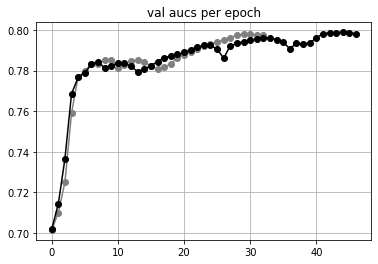

In [9]:
# running the model

try:
    sess
except NameError:
    pass
else:
    sess.close()

sess = tf.Session() # we don't want to close the session

learning_rate=.001
epochs=150
l2_loss_term = .001 * sum([tf.reduce_sum(tf.reshape(weight*weight, [-1])) for weight in all_weights])
mse_loss_term = tf.reduce_mean(tf.squared_difference(pred_y, y_true))
ce_loss_term = -(tf.reduce_mean(((y_true+1)/2)*tf.math.log((pred_y+1)/2)+(1-(y_true+1)/2)*tf.math.log(1-(pred_y+1)/2)))
# ce_loss_term = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=l3))
loss = ce_loss_term
# + l2_loss_term
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

init = tf.global_variables_initializer()

flat_val_ys = [(1 if y[0] > y[1] else 0) for y in val_ys]

min_acc_auc = (math.inf, math.inf)

sess.run(init)

val_accs = []
val_aucs = []

# tensorboard doesn't work with tensorflow 1 anymore... 
# ill fucking switch to pytorch before touching tf2
# current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
# test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
# train_file_writer = tf.summary.FileWriter(train_log_dir, sess.graph)
# test_file_writer = tf.summary.FileWriter(test_log_dir, sess.graph)

with open("prev_run_stats.pickle", "rb") as prev_run_file:
    _, prev_run_scores, _, prev_best_auc_run = pickle.load(prev_run_file)
    _, prev_best_aucs = prev_run_scores[prev_best_auc_run]

max_val_auc = 0


for epoch in tqdm(range(epochs), leave=False):
    print("epoch", epoch)
    print("training")    
    for b_tags, b_user_Xs, b_movie_Xs, b_genres, b_ys in batchify(train_tags, user_Xs, movie_Xs, train_genres, ys, batch_size=497774, shuffle=False):
        feed_dict = {user_slice_idxs: b_user_Xs, 
                     movie_slice_idxs: b_movie_Xs, 
                     movie_genre_embeddings: b_genres,
                     tags: b_tags,
                     y_true: b_ys}
        outs = (train_step, loss, l2_loss_term, ce_loss_term)
        _, lossval, l2_lossval, mse_lossval = sess.run(outs, feed_dict=feed_dict)
#         print("pred_ys", pred_y_val, "true_ys", b_ys[:5])
        print("train loss", lossval, "l2", l2_lossval, "mse", mse_lossval)

#         with train_file_writer as writer:
#             writer.add_summary(tf.summary.scalar("loss", loss))

    feed_dict = {user_slice_idxs: user_val_Xs,
                movie_slice_idxs: movie_val_Xs,
                movie_genre_embeddings: val_genres,
                tags: val_tags,
                y_true: val_ys}
    val_y_pred, val_loss_val = sess.run((pred_y, loss), feed_dict=feed_dict)
    flat_pred_y_floats = [y[0]/(y[0]+y[1]) for y in val_y_pred]
    flat_pred_y_bools = [(1 if y[0] > y[1] else 0) for y in val_y_pred]

    print("val loss", val_loss_val)
    acc = metrics.accuracy_score(flat_val_ys, flat_pred_y_bools)
    fpr, tpr, _ = metrics.roc_curve(flat_val_ys, flat_pred_y_floats)
    auc = metrics.auc(fpr, tpr)
    print("val acc", acc, "val auc", auc)
    min_acc_auc = min(min_acc_auc, (acc, auc))
    val_accs.append(acc)
    val_aucs.append(auc)
    
    plt.clf()
    plt.title("val aucs per epoch")
    plt.grid(b=True)
    plt.plot(prev_best_aucs, marker='o', color="grey")
    plt.plot(val_aucs, marker='o', color="black")
    plt.savefig("cur_val_aucs.png")
    
    
    cur_best_auc = max(val_aucs)
    if auc < cur_best_auc * .9 and epoch > 10:
        print("detecting overfitting - stopping to avoid boiling oceans")
        break
    
#     with test_file_writer as writer:
#         writer.add_summary(value=[tf.summary.Value(tag="loss", simple_value=val_loss_val)])
#         writer.add_summary(tf.summary.scalar("loss", loss))
#         writer.add_summary(value=[tf.summary.Value(tag="acc", simple_value=acc)])
#         writer.add_summary(value=[tf.summary.Value(tag="auc", simple_value=auc)])



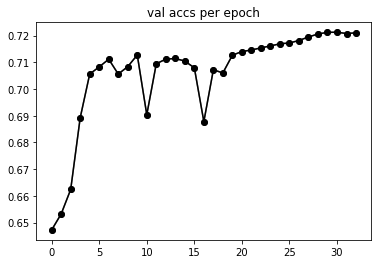

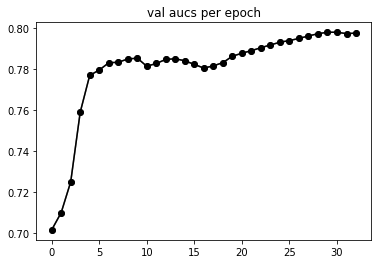

best run: 22


In [8]:
# im reduced to manually tensorboarding like a loser cause tf2 api is being a dick not my fault

with open("prev_run_stats.pickle", "rb") as prev_run_file:
    cur_run, run_scores, best_auc, best_auc_run = pickle.load(prev_run_file)

run_scores[cur_run] = (val_accs, val_aucs)
if max(val_aucs) > best_auc:
    best_auc, best_auc_run = val_aucs[-1], cur_run

cur_run += 1
best_accs, best_aucs = run_scores[best_auc_run]

with open("prev_run_stats.pickle", "wb+") as prev_run_file:
    pickle.dump((cur_run, run_scores, best_auc, best_auc_run), prev_run_file)

plt.title("val accs per epoch")
plt.plot(best_accs, marker='o', color="grey")
plt.plot(val_accs, marker='o', color="black")
plt.show()

plt.title("val aucs per epoch")
plt.plot(best_aucs, marker='o', color="grey")
plt.plot(val_aucs, marker='o', color="black")
plt.show()

print(f"best run: {best_auc_run}")

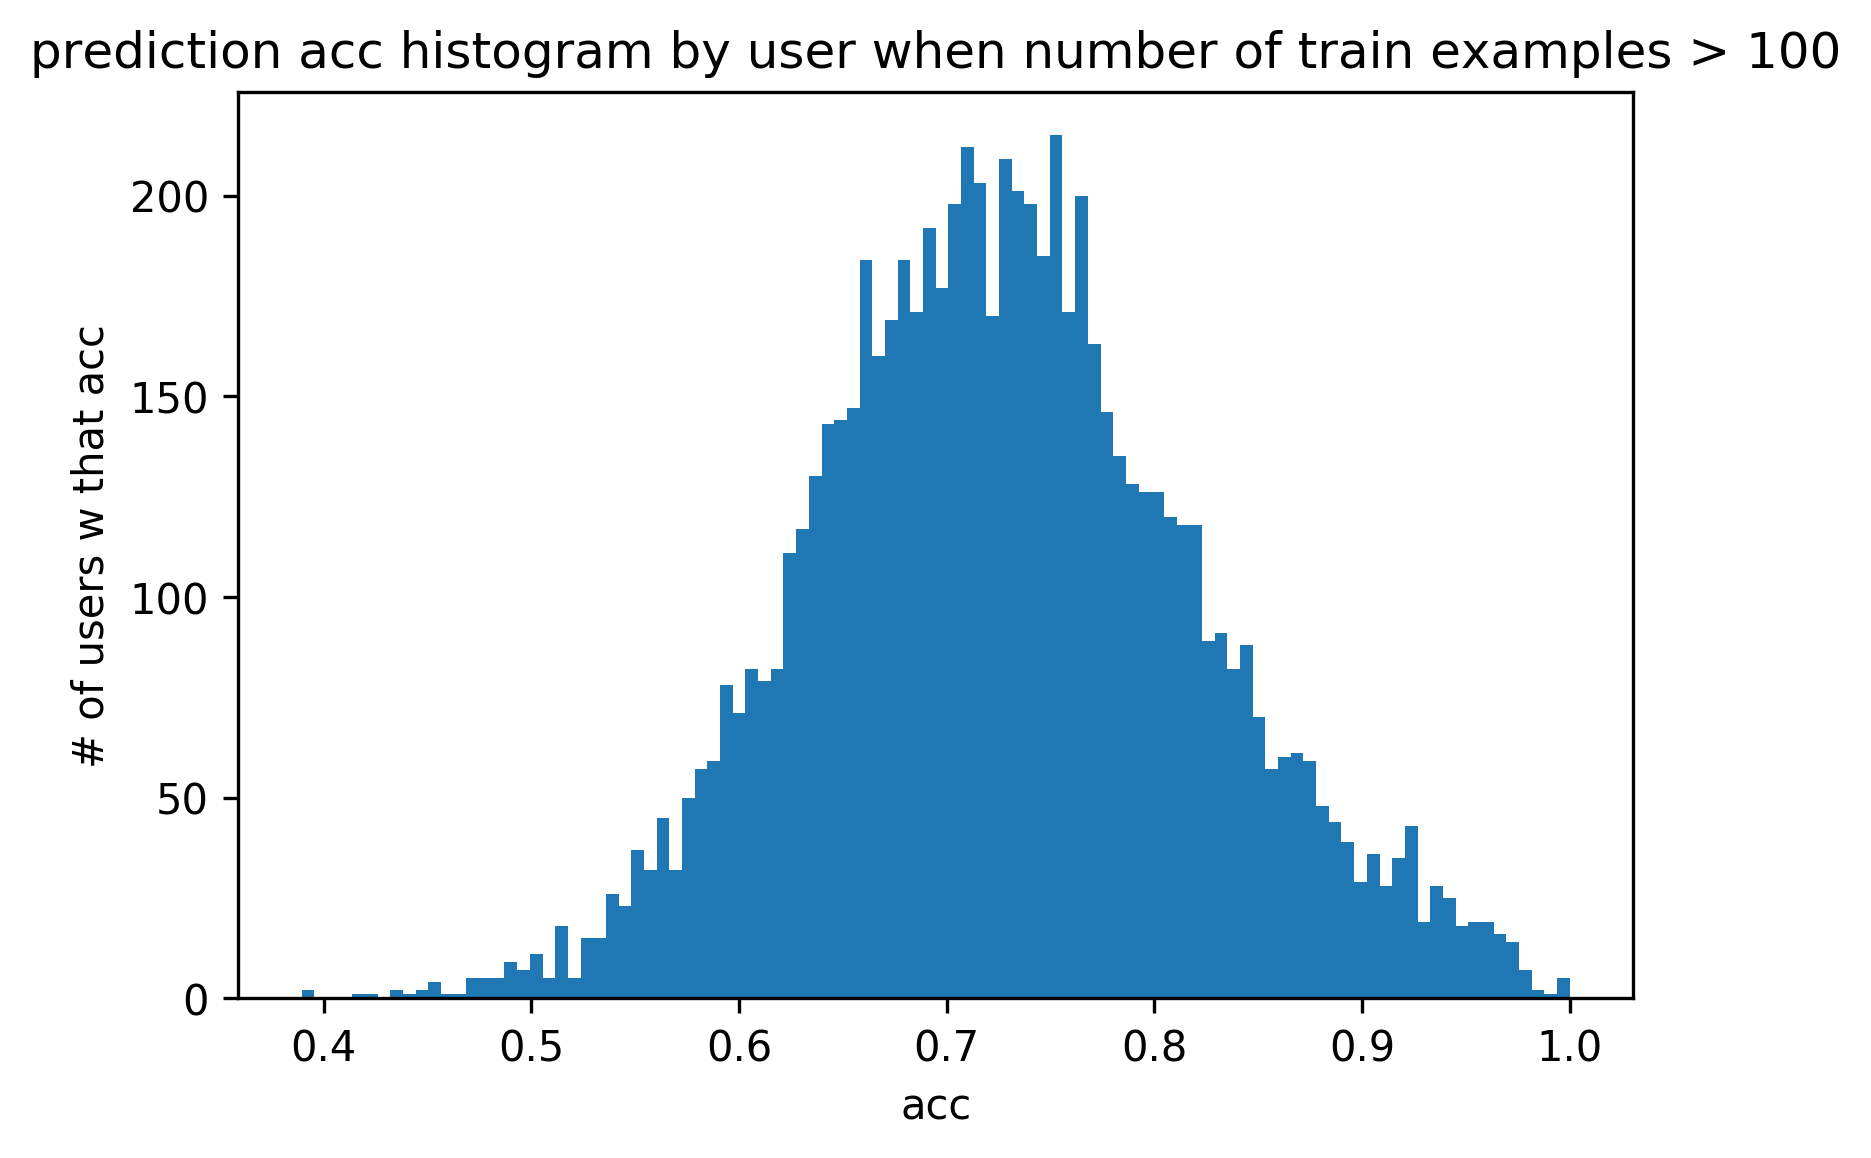

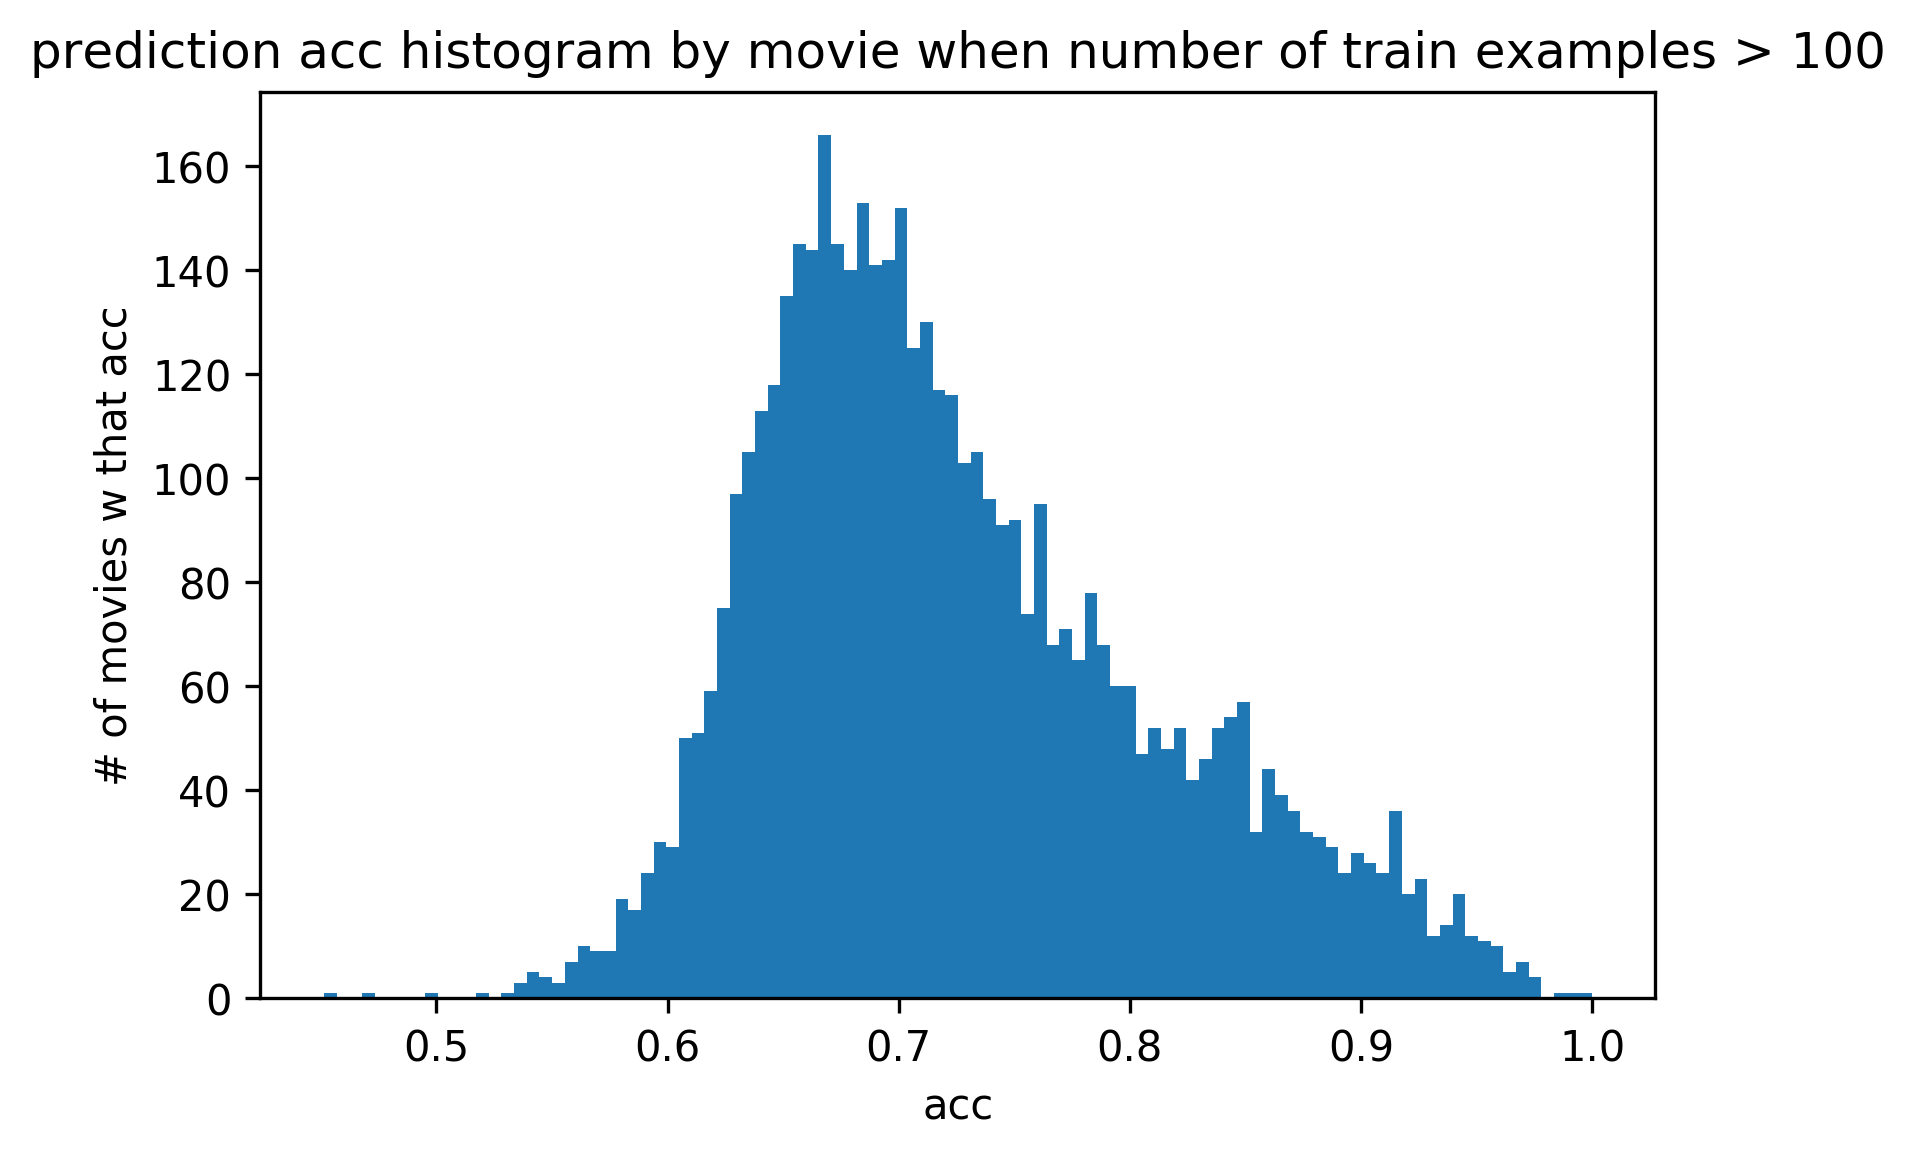

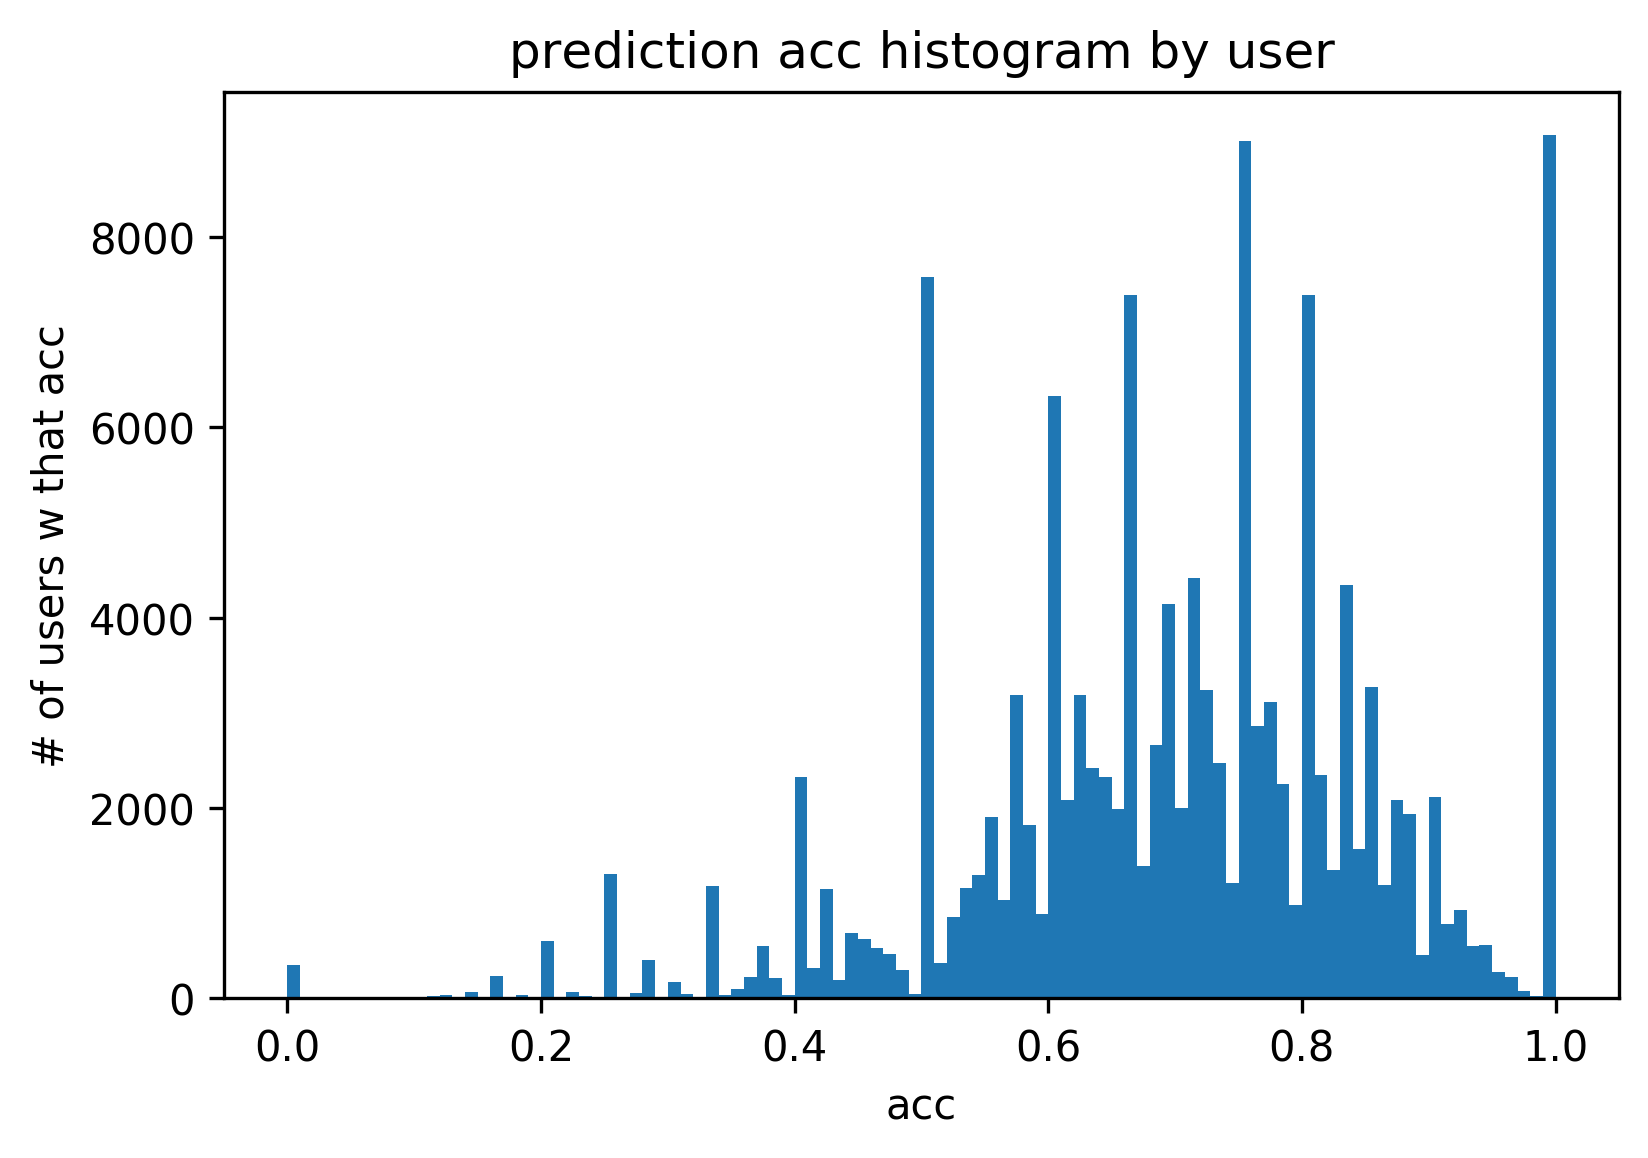

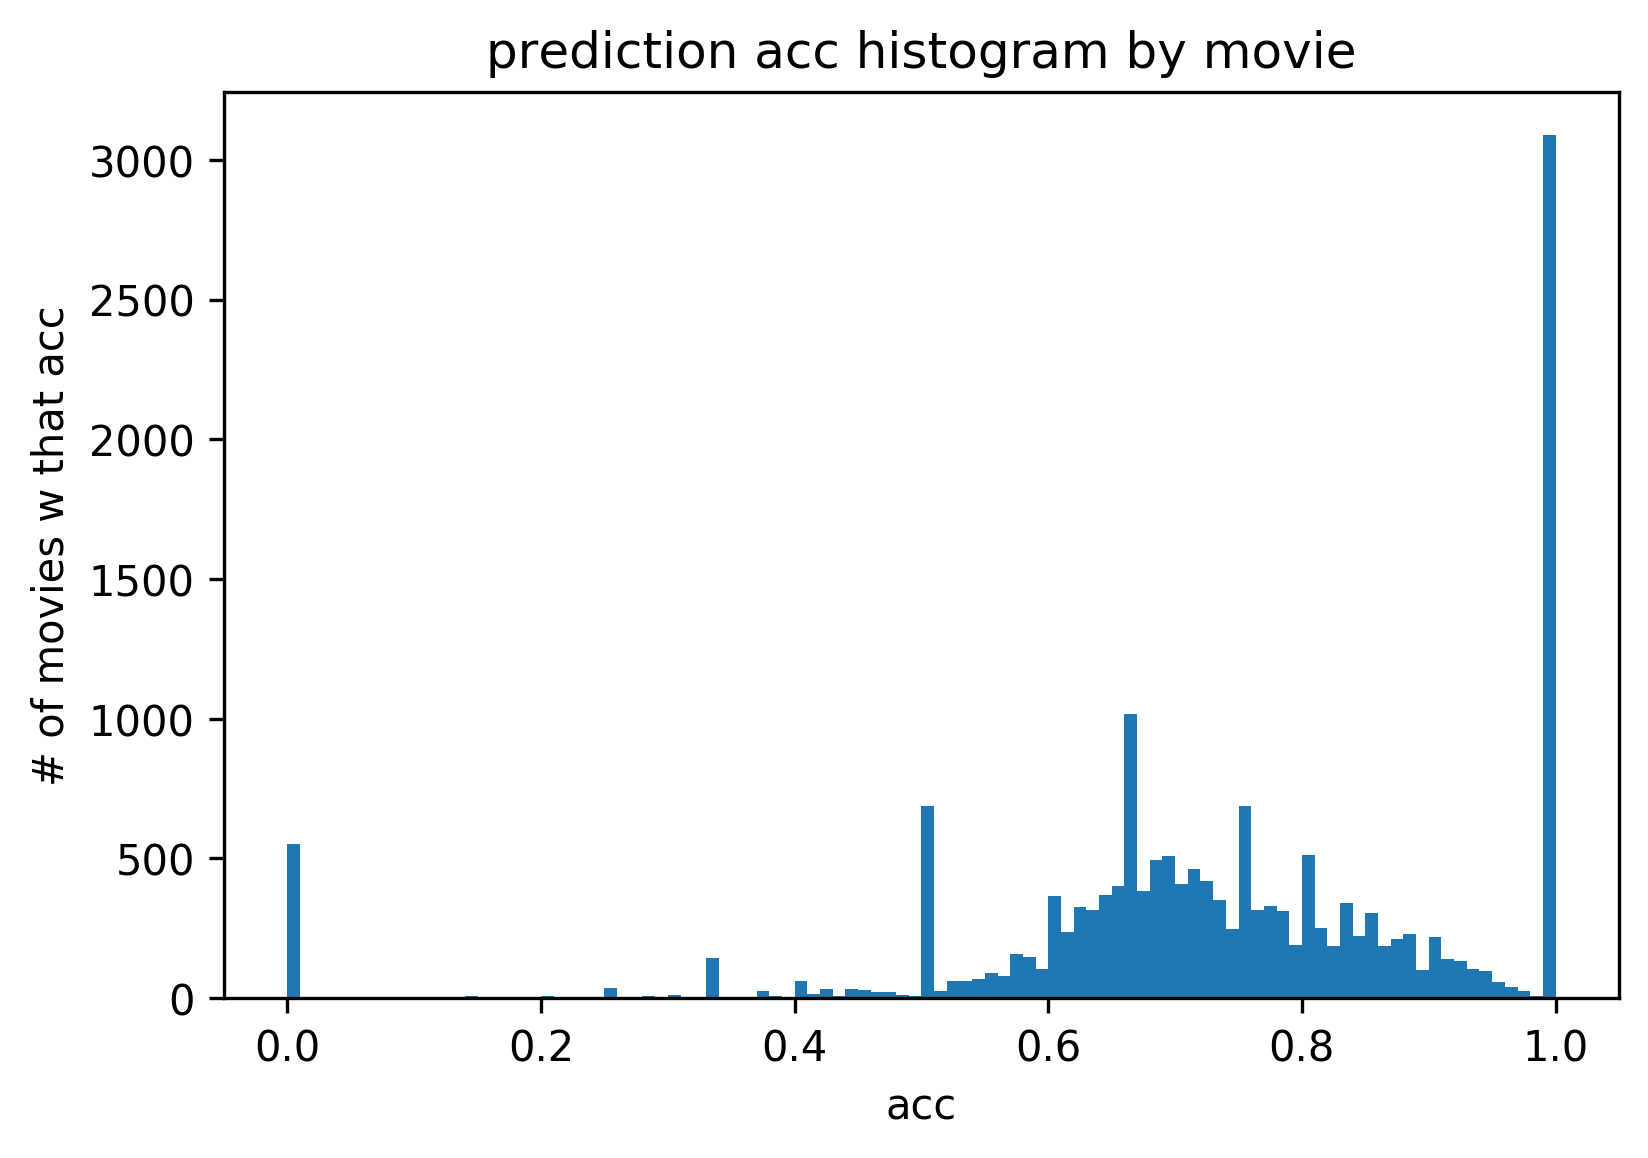

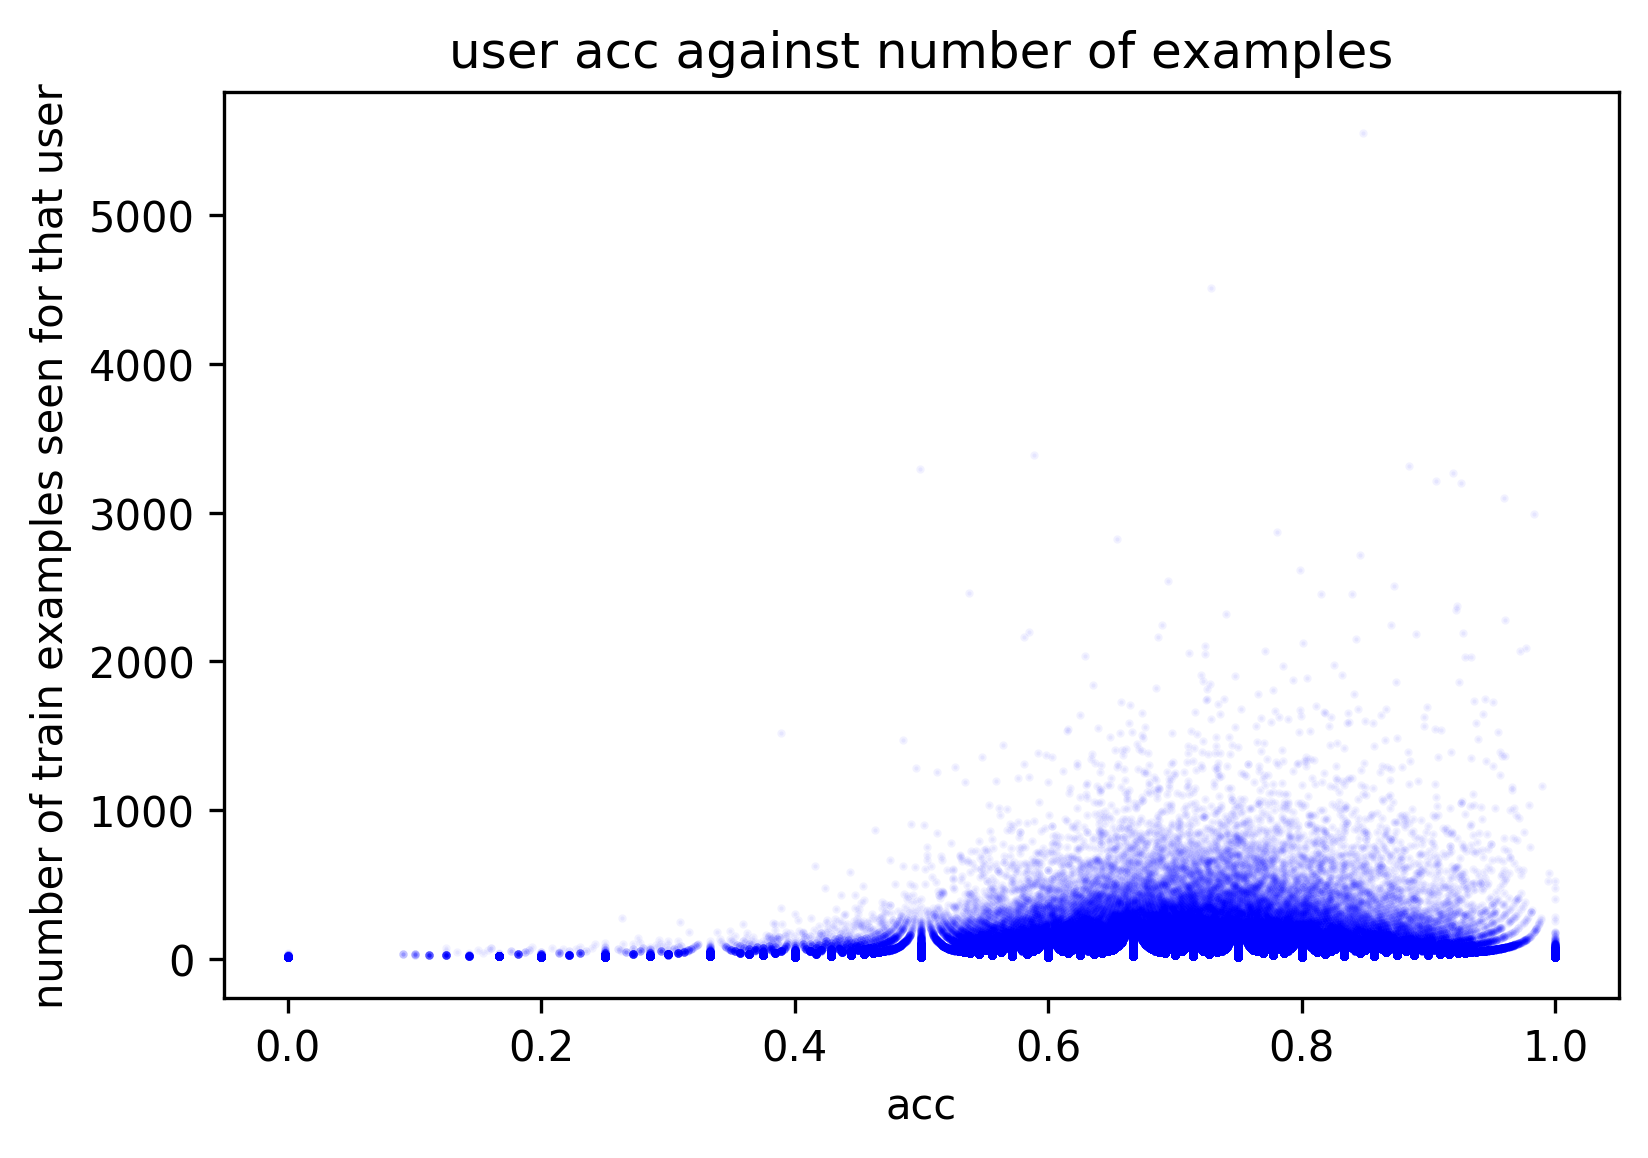

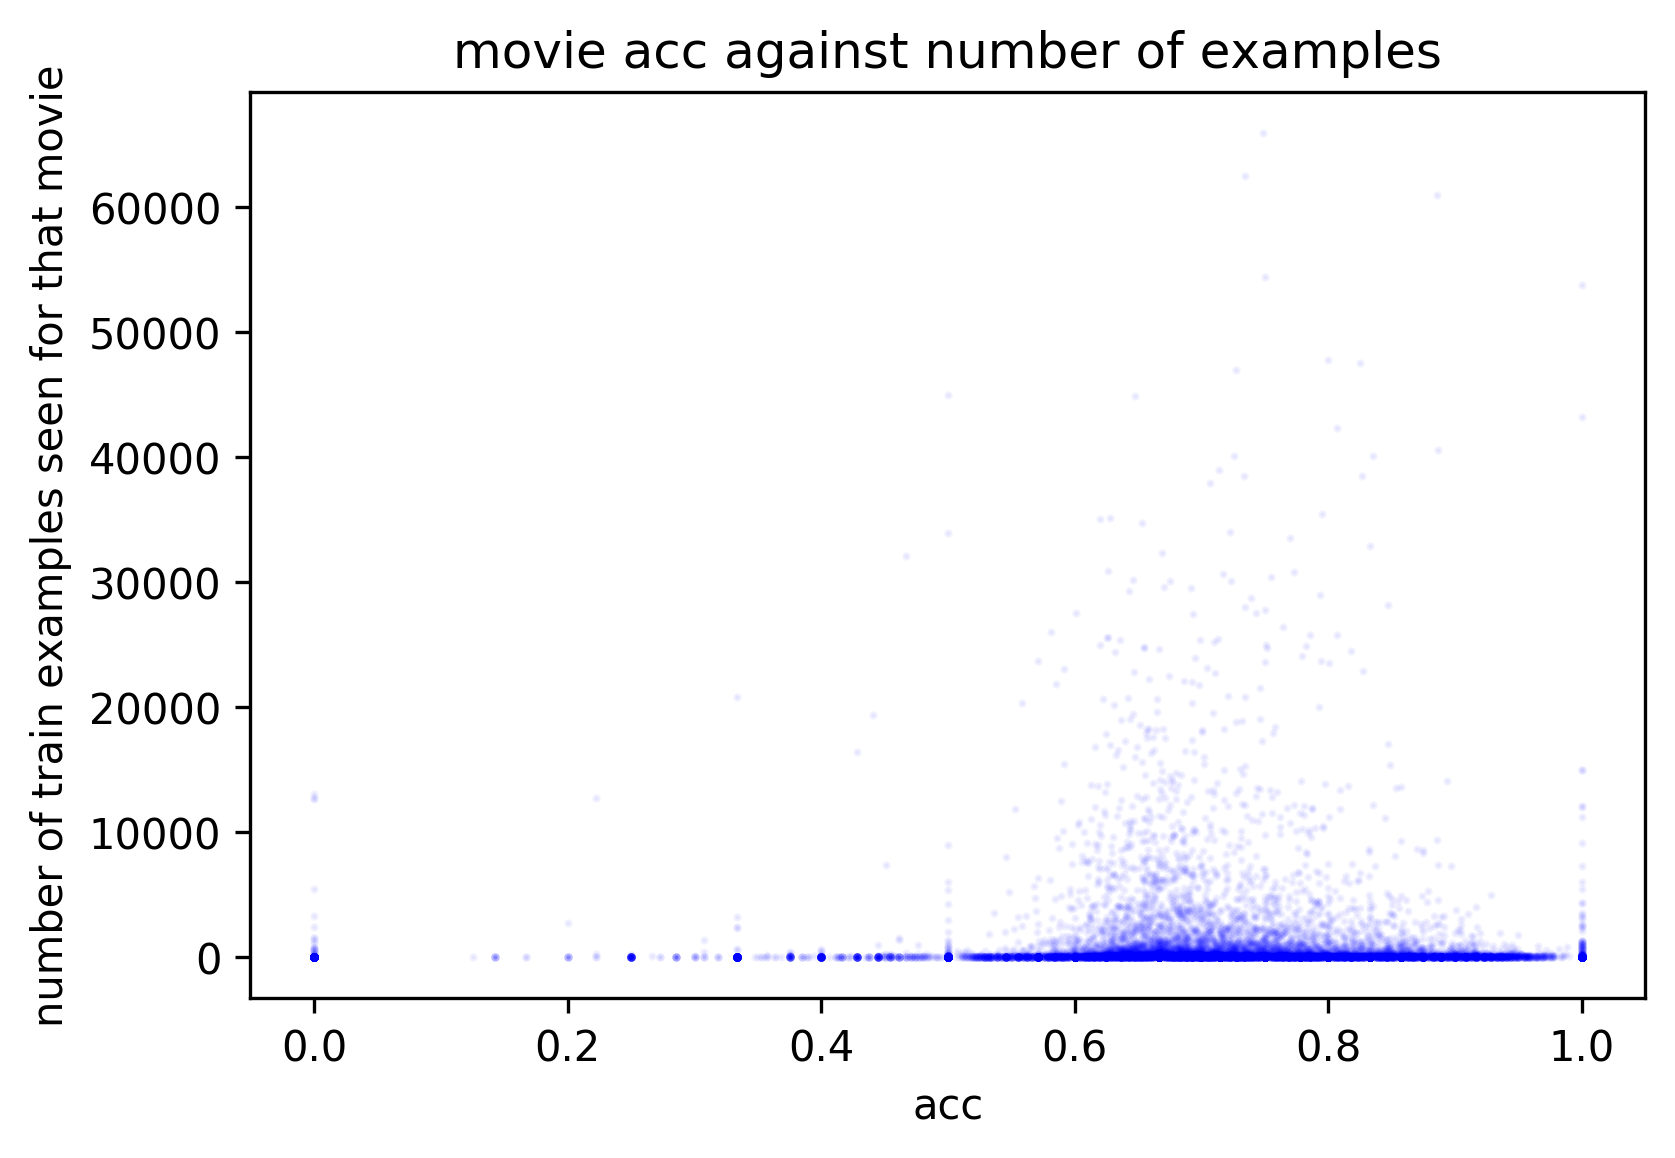

In [53]:
# prediction acc by user and by movie
plt.rcParams['figure.dpi'] = 300

user_correct_ct = defaultdict(lambda: 0)
user_total_ct = defaultdict(lambda: 0)
movie_correct_ct = defaultdict(lambda: 0)
movie_total_ct = defaultdict(lambda: 0)
for uid, mid, y_true, pred_y in tqdm(zip(user_val_Xs, movie_val_Xs, val_ys, val_y_pred)):
    uid = uid[0]
    mid = mid[0]
    if (y_true[0] > y_true[1]) == (pred_y[0] > pred_y[1]):
        user_correct_ct[uid] += 1
        movie_correct_ct[mid] += 1
    user_total_ct[uid] += 1
    movie_total_ct[mid] += 1

user_accs = defaultdict(lambda: -1)
movie_accs = defaultdict(lambda: -1)
for uid, total in tqdm(user_total_ct.items()):
    if total > 100:
        correct_ct = user_correct_ct[uid]
        user_accs[uid] = correct_ct/total

for mid, total in tqdm(movie_total_ct.items()):
    if total > 100:
        correct_ct = movie_correct_ct[mid]
        movie_accs[mid] = correct_ct/total

plt.title("prediction acc histogram by user when number of train examples > 100")
plt.hist(user_accs.values(), bins=100)
plt.xlabel("acc")
plt.ylabel("# of users w that acc")
plt.show()
plt.title("prediction acc histogram by movie when number of train examples > 100")
plt.hist(movie_accs.values(), bins=100)
plt.xlabel("acc")
plt.ylabel("# of movies w that acc")
plt.show()

user_accs = defaultdict(lambda: -1)
movie_accs = defaultdict(lambda: -1)
for uid, total in tqdm(user_total_ct.items()):
    correct_ct = user_correct_ct[uid]
    user_accs[uid] = correct_ct/total

for mid, total in tqdm(movie_total_ct.items()):
    correct_ct = movie_correct_ct[mid]
    movie_accs[mid] = correct_ct/total

plt.title("prediction acc histogram by user")
plt.hist(user_accs.values(), bins=100)
plt.xlabel("acc")
plt.ylabel("# of users w that acc")
plt.show()
plt.title("prediction acc histogram by movie")
plt.hist(movie_accs.values(), bins=100)
plt.xlabel("acc")
plt.ylabel("# of movies w that acc")
plt.show()

user_train_examples_ct = defaultdict(lambda: 0)
movie_train_examples_ct = defaultdict(lambda: 0)

for uid, mid in zip(user_Xs, movie_Xs):
    user_train_examples_ct[uid[0]] += 1
    movie_train_examples_ct[mid[0]] += 1

user_acc_examples = np.array([(user_accs[uid], ct) for uid, ct in user_train_examples_ct.items()])
movie_acc_examples = np.array([(acc, movie_train_examples_ct[mid]) for mid, acc in movie_accs.items()])
plt.title("user acc against number of examples")
plt.scatter(user_acc_examples[:, 0], user_acc_examples[:, 1], c=[[0, 0, 1, .05]], s=1)
plt.xlabel("acc")
plt.ylabel("number of train examples seen for that user")
plt.show()
plt.title("movie acc against number of examples")
plt.scatter(movie_acc_examples[:, 0], movie_acc_examples[:, 1], c=[[0, 0, 1, .05]], s=1)
plt.xlabel("acc")
plt.ylabel("number of train examples seen for that movie")
plt.show()

# conclusion: highest acc gains can be made by tailoring movie suggestions to specific users with low information

In [52]:
# prediction acc by genre

genre_correct_ct = defaultdict(lambda: 0)
genre_total_ct = defaultdict(lambda: 0)

movie_genres_one_hot = get_movie_genres_one_hot()
for uid, mid, y_true, pred_y in tqdm(zip(user_val_Xs, movie_val_Xs, val_ys, val_y_pred)):
    genres = movie_genres_one_hot[mid[0]]
    correct = (y_true[0] > y_true[1]) == (pred_y[0] > pred_y[1])
    for i, genre in enumerate(genres):
        if genre == 1:
            genre_correct_ct[i] += correct
            genre_total_ct[i] += 1

print("prediction acc by genre")
for genre_id, total in genre_total_ct.items():
    correct_ct = genre_correct_ct[genre_id]
    print(genre_id, correct_ct/total)
    
# conclusion: genre can't really be mined for more information i think


prediction acc by genre
0 0.6995159534525215
2 0.7159841054082343
9 0.7185833520711747
1 0.7149753041763631
8 0.7119309107628237
11 0.7090133506421912
13 0.7100267627207083
3 0.6995048881632122
4 0.725013637355444
5 0.7159867831486766
10 0.7011777866560128
17 0.7159786912799476
6 0.7305992968686126
14 0.6775549503847784
15 0.691932549768414
12 0.7200485173131068
16 0.7185653542437462
19 0.712829162132753
7 0.6874646026052482


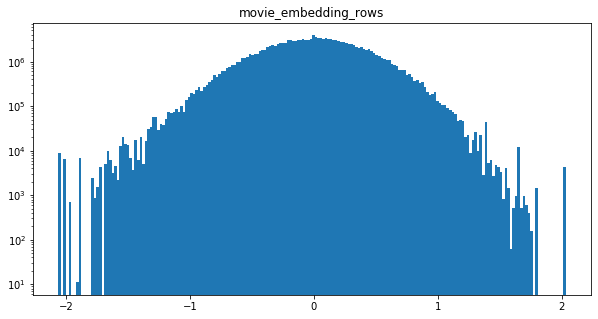

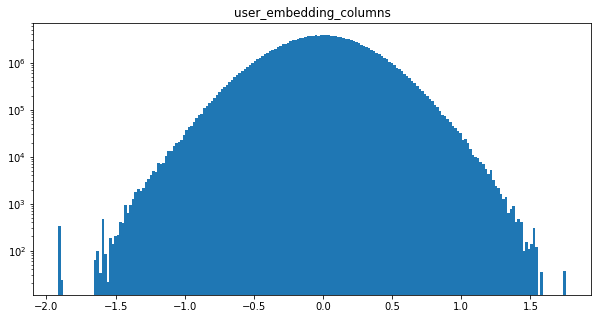

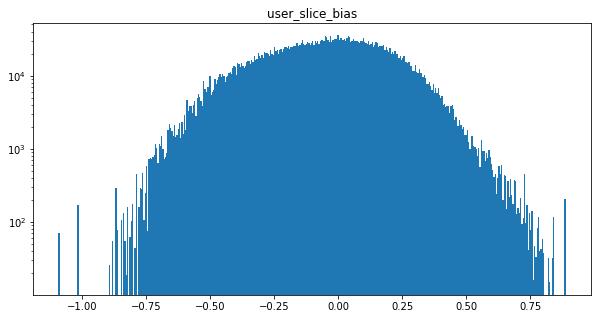

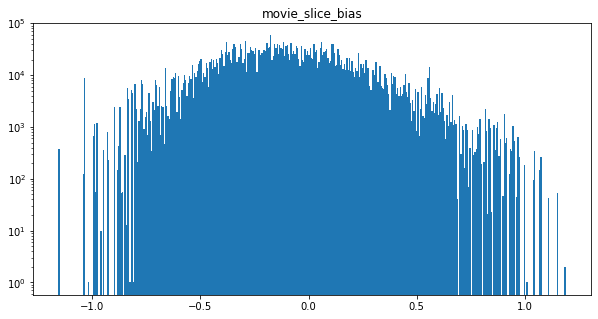

In [19]:
plt.rc('figure', figsize=(10, 5))
plt.title("movie_embedding_rows")
plt.hist(sess.run(movie_embedding_rows, feed_dict).flatten(), log=True, bins=200)
plt.show()
plt.title("user_embedding_columns")
plt.hist(sess.run(user_embedding_columns, feed_dict).flatten(), log=True, bins=200)
plt.show()
plt.title("user_slice_bias")
plt.hist(sess.run(user_slice_bias, feed_dict).flatten(), log=True, bins=400)
plt.show()
plt.title("movie_slice_bias")
plt.hist(sess.run(movie_slice_bias, feed_dict).flatten(), log=True, bins=400)
plt.show()

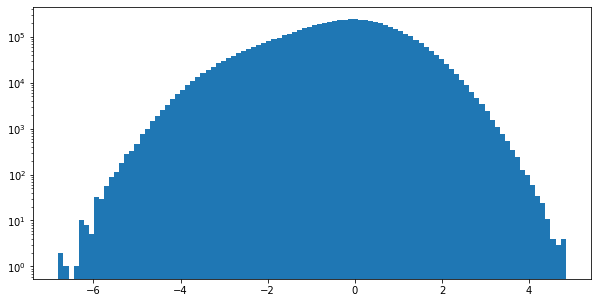

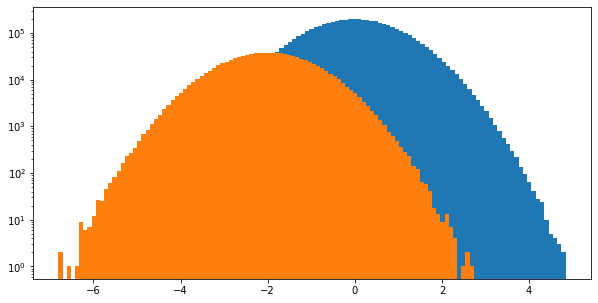

In [136]:
mode1 = np.random.normal(0, 1, 5000000)
mode2 = np.random.normal(-2, 1, 1000000)

plt.hist(np.concatenate((mode1, mode2)), bins=100, log=True)
plt.show()
plt.hist(mode1, bins=100, log=True)
plt.hist(mode2, bins=100, log=True)
plt.show()


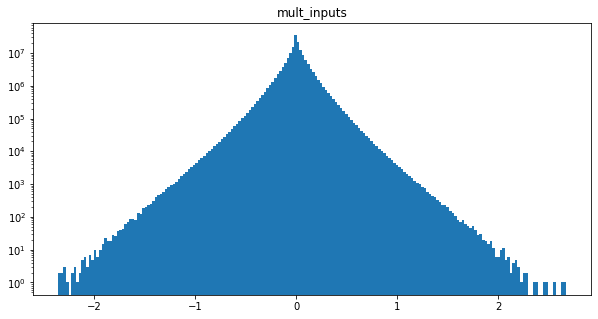

avg pos -0.00021177795315711342 pos ct 76948440
avg neg -4.119220633618965e-05 neg ct 83021000


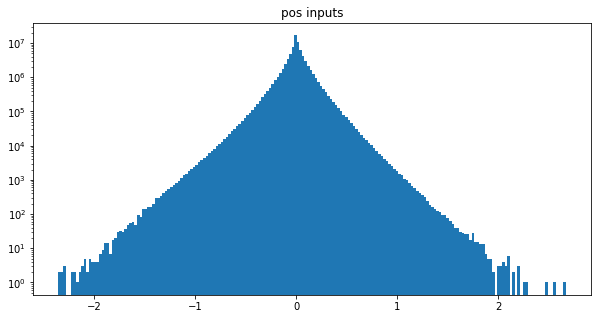

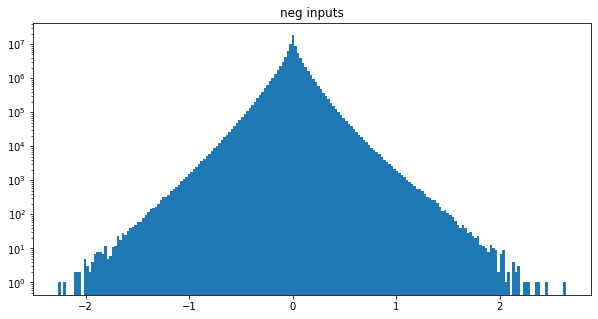

In [20]:
mult_inputs = sess.run(mult_input, feed_dict)
plt.cla()
plt.title("mult_inputs")
plt.hist(mult_inputs.flatten(), log=True, bins=200)
plt.show()

pred_ys = sess.run(pred_y, feed_dict)

mult_input_pos = np.array([mult_input for mult_input, pred in zip(mult_inputs, pred_ys) if pred[0] > pred[1]]).flatten()
if len(mult_input_pos) > 0:
    print("avg pos", sum(mult_input_pos)/len(mult_input_pos), "pos ct", len(mult_input_pos))
else:
    print("mult_input_pos", mult_input_pos)

mult_input_neg = np.array([mult_input for mult_input, pred in zip(mult_inputs, pred_ys) if pred[0] <= pred[1]]).flatten()
if len(mult_input_neg) > 0:
    print("avg neg", sum(mult_input_neg)/len(mult_input_neg), "neg ct", len(mult_input_neg))
else:
    print("mult_input_neg", mult_input_neg)

plt.title("pos inputs")
plt.hist(mult_input_pos, bins=200, log=True)
plt.show()
plt.title("neg inputs")
plt.hist(mult_input_neg, bins=200, log=True)
plt.show()

# makes sense why these are basically chi square - composed of normal distributions multiplied together which is fundamentally what we're predicting